## Notebook Overview

In this notebook, we will take a closer look at  Insurance Claims and figure out some facts about how conditions such as blood pressure, BMI, diabetes, smoking, age, and gender impact the claim value.

We will touch the topics through exploratory data analysis (EDA) using scatter plots, pie charts, histograms etc.

Later we build models, and evaluate them. 

Finally, we make predictions, and gauge the predicted figures.

In [1]:
## Import relevant libraries for data processing & visualisation 

import numpy as np              # linear algebra
import pandas as pd             # data processing, dataset file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization & graphical plotting
import seaborn as sns           # to visualize random distributions
%matplotlib inline

## Add additional libraries to prepare and run the model

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor

import warnings                 # to deal with warning messages
warnings.filterwarnings('ignore')

In [2]:
## Import the dataset to read and analyse
df_ins = pd.read_csv("/kaggle/input/insurance-claim-analysis-demographic-and-health/insurance_data.csv")

## Data Processing & Data Preparation for EDA 

In [3]:
# checking the datasct contents, with head() function
df_ins.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


#### Checking the null values, and filling them appropriately

In [4]:
## Checking the null values with isna() function
df_ins.isna().sum()

index            0
PatientID        0
age              5
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           3
claim            0
dtype: int64

It is observed that age feature has 5 records with null value, and region feature has 3 records with null values.

In [5]:
## interpolating the null values
df = df_ins.interpolate()                ## numerical features
df = df_ins.fillna(df.mode().iloc[0])    ## categorical features
df.isna().sum()                          ## check for any null values, after modifying

index            0
PatientID        0
age              0
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           0
claim            0
dtype: int64

In [6]:
## Having a more deeper look into the data, gauging descriptive data for each feature
df.describe(include='all').round(0)

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
count,1340.0,1340.0,1340.0,1340,1340.0,1340.0,1340,1340.0,1340,1340,1340.0
unique,NaN,NaN,NaN,2,NaN,NaN,2,NaN,2,4,NaN
top,NaN,NaN,NaN,male,NaN,NaN,No,NaN,No,southeast,NaN
freq,NaN,NaN,NaN,678,NaN,NaN,698,NaN,1066,446,NaN
mean,670.0,670.0,38.0,NaN,31.0,94.0,NaN,1.0,NaN,NaN,13253.0
std,387.0,387.0,11.0,NaN,6.0,11.0,NaN,1.0,NaN,NaN,12110.0
min,0.0,1.0,18.0,NaN,16.0,80.0,NaN,0.0,NaN,NaN,1122.0
25%,335.0,336.0,29.0,NaN,26.0,86.0,NaN,0.0,NaN,NaN,4720.0
50%,670.0,670.0,38.0,NaN,30.0,92.0,NaN,1.0,NaN,NaN,9370.0
75%,1004.0,1005.0,47.0,NaN,35.0,99.0,NaN,2.0,NaN,NaN,16604.0


In [7]:
## Checking the shape of the dataset
print("The number of rows and number of columns are ", df.shape)

The number of rows and number of columns are  (1340, 11)


In [8]:
## Checking the labels in categorical features
for col in df.columns:
    if df[col].dtype=='object':
        print()
        print(col)
        print(df[col].unique())


gender
['male' 'female']

diabetic
['Yes' 'No']

smoker
['No' 'Yes']

region
['southeast' 'northwest' 'southwest' 'northeast']


In [9]:
## Relabeling the categories in 'diabetic', 'smoker' variables appropriatly with .replace() function
## This helps in having a greater understanding of contents in charts & plots
df['diabetic'] = df['diabetic'].replace({'Yes': 'diabetic', 'No': 'non-diabetic'})
df['smoker'] = df['smoker'].replace({'Yes': 'smoker', 'No': 'non-smoker'})

In [10]:
# Before proceeding to EDA, see the information about the DataFrame with .info() function
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1340 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1340 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


## Exploratory Data Analysis_EDA

#### Countplot By Region, Gender

In [11]:
## First we will use pd.crosstab() to check the data in tabular format
pd.crosstab(df['region'], df['gender'], margins = True, margins_name = "Total").sort_values(by="Total", ascending=True)

gender,female,male,Total
region,,,
northeast,112,119,231
southwest,162,152,314
northwest,164,185,349
southeast,224,222,446
Total,662,678,1340


- Since we have only 4 categories, we can quickly makeout some info from the table
- However, when categories number is high, itis difficult to gain insights from the table
- Thats' where visualising would be the better option

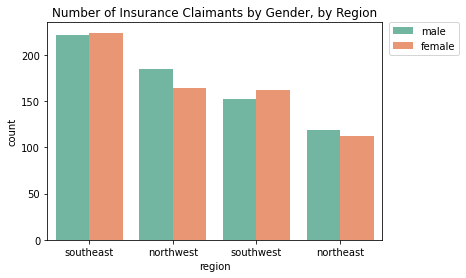

In [12]:
## Now we use countplot() to visualise the data
sns.countplot(x='region', hue='gender', palette="Set2", data=df).set(title='Number of Insurance Claimants by Gender, by Region')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

- The above plot revealts that southeast has higher claims overall
- southeast, southwest have higher female claims; northwest, northeast, have higher male claims

#### Boxplot by Gender vs Age

[Text(0.5, 1.0, 'Number of Insurance Claimants by Gender, by Age')]

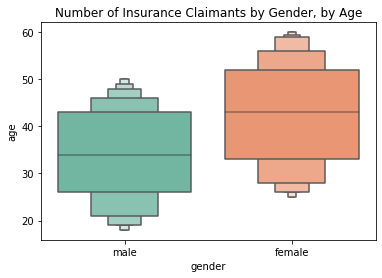

In [13]:
## Boxplot gender vs age of insurance claimants
sns.boxenplot(x='gender', y='age', palette="Set2", data=df).set(title='Number of Insurance Claimants by Gender, by Age')

- The plot shows age of female insurance claimants is higher, has a higher median than males

#### Boxplot By Region, Claim Value, Gender

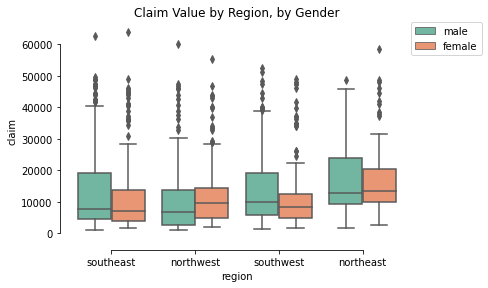

In [14]:
sns.boxplot(x="region", y="claim",hue="gender", palette="Set2",data=df).set(title='Claim Value by Region, by Gender')
sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0)

- The plot revealts that claim median value lies in the rang of around 
- 10,000-15,000 for all the regions, for both the genders
- Claim value outliers are rampant for all the regions, for both the genders

#### Histograms for numerical variables

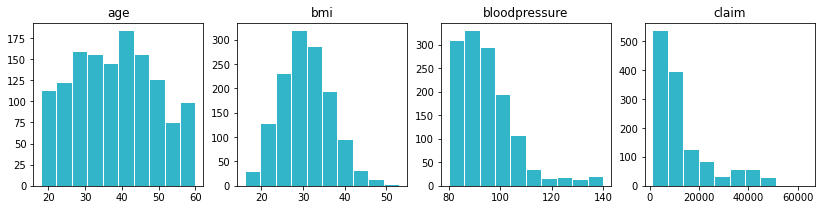

In [15]:
## Generating histograms for numerical variables –– age, bmi, bloodpressure, claim
fig, axes = plt.subplots(1, 4, figsize=(14,3))
age = df.age.hist(ax=axes[0], color="#32B5C9", ec="white", grid=False).set_title('age')
bmi = df.bmi.hist(ax=axes[1], color="#32B5C9", ec="white", grid=False).set_title('bmi')
bloodpressure = df.bloodpressure.hist(ax=axes[2], color="#32B5C9", ec="white", grid=False).set_title('bloodpressure')
claim = df.claim.hist(ax=axes[3], color="#32B5C9", ec="white", grid=False).set_title('claim')

Histograms generated show
   - age of individuals is more or less equally distributed
   - bmi displays a typical normal distribution
   - bloodpressure & claims have higher positive skewness

#### Scatterplots

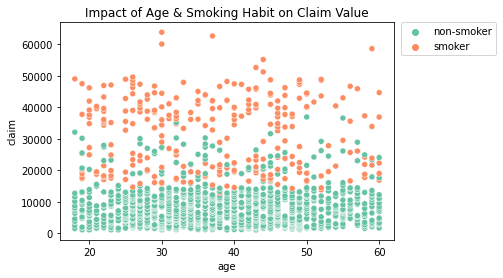

In [16]:
## Scatterplots help in understanding the impact of habits & health conditions on insurance claim value
## Let us try analyse the impact of smoking habit and age on claim value
sns.scatterplot(x='age', y='claim', hue='smoker', palette="Set2", data=df).set(title='Impact of Age & Smoking Habit on Claim Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0)
plt.show()

 - The plot reveals that claim value is typiclly high for people with smoking habit 

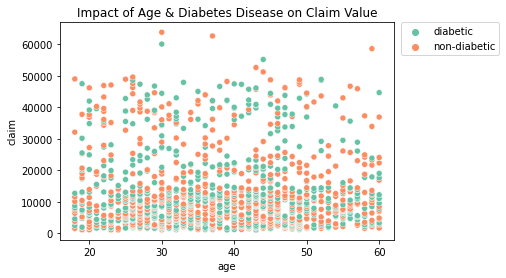

In [17]:
## Impact of diabetes disease and age on claim value
sns.scatterplot(x='age', y='claim', hue='diabetic', palette="Set2", data=df).set(title='Impact of Age & Diabetes Disease on Claim Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0)
plt.show()

 - The plot reveals that there is no significant correlation between claim value and prevalence of diabetes 

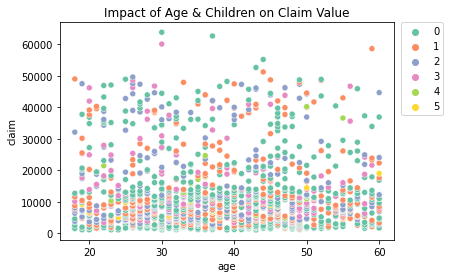

In [18]:
## Impact of no. of children and age on claim value 
sns.scatterplot(x='age', y='claim', hue='children', palette="Set2", data=df).set(title='Impact of Age & Children on Claim Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0)
plt.show()

 - The plot reveals that there is no significant correlation between claim value and number of children the claim holder has

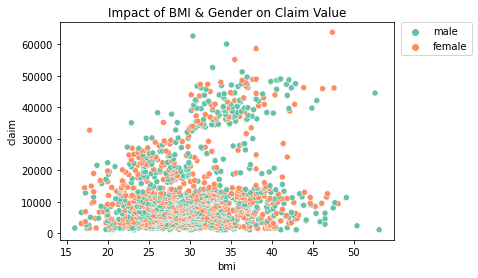

In [19]:
## Impact of bmi on claim value, by gender
sns.scatterplot(x='bmi', y='claim', hue='gender', palette="Set2", data=df).set(title='Impact of BMI & Gender on Claim Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0)
plt.show()

 - The plot reveals that there is certain degree of correlation between claim value and bmi, in both male & female groups

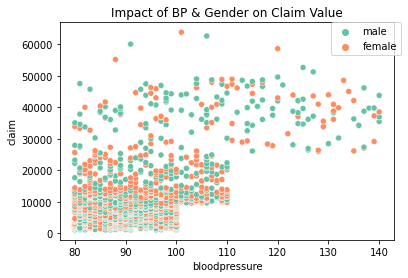

In [20]:
## Impact of bloodpressure on claim value, by gender
sns.scatterplot(x='bloodpressure', y='claim', hue='gender', palette="Set2", data=df).set(title='Impact of BP & Gender on Claim Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0)
plt.show()

 - The plot reveals that there is some correlation between claim value and bloodpressure, in both male & female groups

#### Pie Charts

In [21]:
## Pie charts help in determining the % share of each category in a feature variable
## First we will define colors for Pie chart (about 6 colors are sufficient here)
colors = ({'custom': 'turquoise', 'silver': 'silver', 'grey': 'grey', 'blue': 'blue', 'lightskyblue': 'lightskyblue', 'white': 'antiquewhite'})

In [22]:
## Total claims by region
regions = df[['region', 'claim']].groupby('region').sum().sort_values(by="claim", ascending=True)
regions

,claim
region,
northeast,3901369.33
southwest,3995062.77
northwest,4073558.87
southeast,5788688.19


array([<AxesSubplot:ylabel='claim'>], dtype=object)

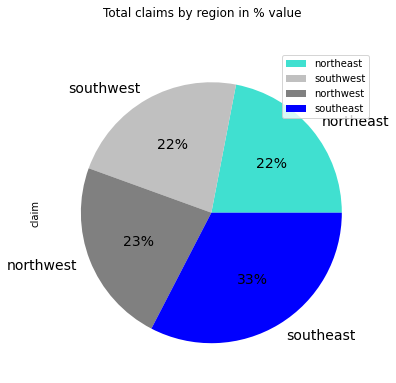

In [23]:
regions.plot(kind='pie', subplots=True, figsize=(10,6), fontsize = 14, colors = colors.values(), title='Total claims by region in % value', autopct='%1.0f%%')

In [24]:
## Total claims by gender
gender = df[['gender', 'claim']].groupby('gender').sum().sort_values(by="claim", ascending=True)
gender

,claim
gender,
female,8321061.23
male,9437617.93


array([<AxesSubplot:ylabel='claim'>], dtype=object)

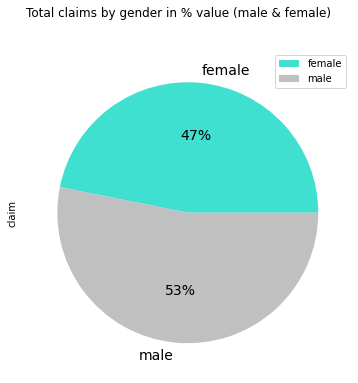

In [25]:
gender.plot(kind='pie', subplots=True, figsize=(10,6), fontsize = 14, colors = colors.values(), title='Total claims by gender in % value (male & female)', autopct='%1.0f%%')

In [26]:
## Total claims by smoking habit
smokers = df[['smoker', 'claim']].groupby('smoker').sum().sort_values(by="claim", ascending=True)
smokers

,claim
smoker,
smoker,8781763.56
non-smoker,8976915.60


array([<AxesSubplot:ylabel='claim'>], dtype=object)

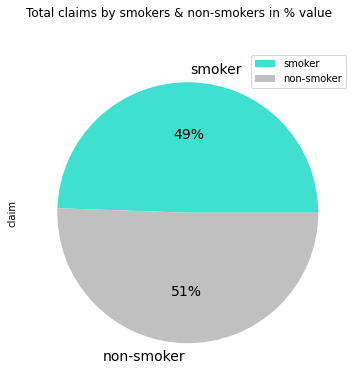

In [27]:
smokers.plot(kind='pie', subplots=True, figsize=(10,6), fontsize = 14, colors = colors.values(), title='Total claims by smokers & non-smokers in % value', autopct='%1.0f%%')

In [28]:
## Total claims by diabetes prevalence
diabetic = df[['diabetic', 'claim']].groupby('diabetic').sum().sort_values(by="claim", ascending=True)
diabetic

,claim
diabetic,
diabetic,8437564.83
non-diabetic,9321114.33


array([<AxesSubplot:ylabel='claim'>], dtype=object)

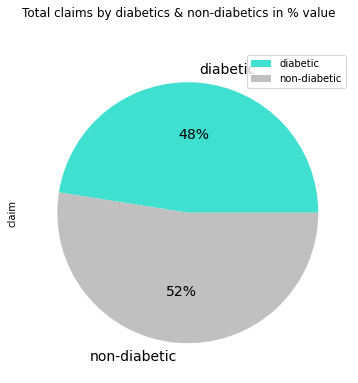

In [29]:
diabetic.plot(kind='pie', subplots=True, figsize=(10,6),fontsize = 14, colors = colors.values(), title='Total claims by diabetics & non-diabetics in % value', autopct='%1.0f%%')

In [30]:
## Total claims by number of children
children = df[['children', 'claim']].groupby('children').sum().sort_values(by="claim", ascending=True)
children

,claim
children,
5,158148.64
4,346266.42
3,2410785.01
2,3617655.36
1,4124899.67
0,7100924.06


array([<AxesSubplot:ylabel='claim'>], dtype=object)

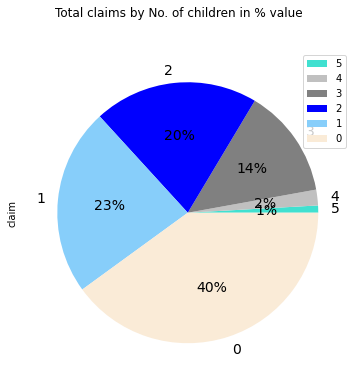

In [31]:
children.plot(kind='pie', subplots=True, figsize=(10,6), fontsize = 14, colors = colors.values(), title='Total claims by No. of children in % value', autopct='%1.0f%%')

#### Building a Pie Chart with Age Groups

 - We have age of individuals in our dataset, but we do not have age group.
 - We create one, by binning using pd.cut() function
 - Before proceeding we build a distribution plot to see age distribution in the dataset
 - later we check minimum, maximum, average ages of the inviduals, for better understanding of ages

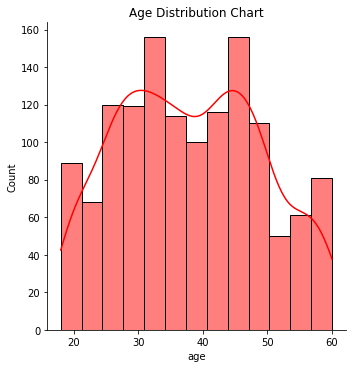

In [32]:
## age distribution plot
sns.displot(df.age, color="r", kde=True).set(title='Age Distribution Chart')

In [33]:
## min, max, mean ages
df['age'].agg(['min', 'max', 'mean']).round(0)

min     18.0
max     60.0
mean    38.0
Name: age, dtype: float64

In [34]:
## Build a new ageGroup feature, with 6 age bands, of 7 years each
age_band = [18,25,32,39,46,53,60]
df['age_group'] = pd.cut(df['age'], bins=age_band)
ageGroup = df[['age_group', 'claim']].groupby('age_group').sum().sort_values(by="claim", ascending=False)
ageGroup

,claim
age_group,
"(25, 32]",3972132.28
"(39, 46]",3726873.10
"(32, 39]",3151344.51
"(46, 53]",2488434.04
"(18, 25]",2461805.34
"(53, 60]",1786511.82


array([<AxesSubplot:ylabel='claim'>], dtype=object)

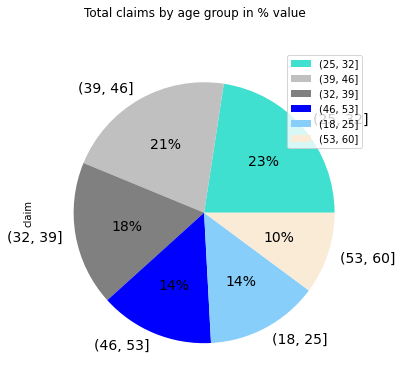

In [35]:
## Total claims by age group 
ageGroup.plot(kind='pie', subplots=True, figsize=(10,6), fontsize = 14, colors = colors.values(), title='Total claims by age group in % value', autopct='%1.0f%%')

## Preparing the Data for Data Modeling

In [36]:
## Now we do some data modeling, model evaluation, and if possible some predictions.
## First we prepare the data to make predictions, and do some feature engineering as per the need
## Later load required additional libraries, and proceed with machine learning

## splitting Categorical and Numerical data
cat_df = df[['gender', 'diabetic', 'children', 'smoker', 'region']]
num_df = df[['age', 'bmi', 'bloodpressure', 'claim']]

In [37]:
## label encoding 
le = LabelEncoder ()

#select ctegorical columns 
cat_df = df.select_dtypes(exclude=["int", "float"])

for i in cat_df:
    cat_df[i] = le.fit_transform(df[i])

#joining the data to the numeric data
num_df = df.select_dtypes(include=['int', 'float'])
main_df = pd.concat([num_df, cat_df], axis=1)

[Text(0.5, 1.0, 'Univariate Analysis : Claim Feature')]

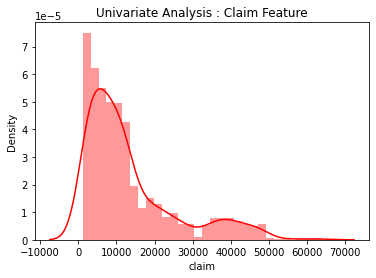

In [38]:
## EDA-Univariate analysis to check "claim" feature, before proceeding with machine learning
sns.distplot(main_df.claim, color="r", kde=True).set(title='Univariate Analysis : Claim Feature')

 - The plot reveals that some outliers exist on higher as well as lower sides, we try to remove them in next step

In [39]:
## Removing the outliers from claim feature
Q1 = np.percentile(main_df['claim'], 25,
                   interpolation = 'midpoint')

Q3 = np.percentile(main_df['claim'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

print("Old Shape: ", main_df.shape)

# Upper bound
upper = np.where(main_df['claim'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(main_df['claim'] <= (Q1-1.5*IQR))

''' Removing the Outliers '''
main_df.drop(upper[0], inplace = True)
main_df.drop(lower[0], inplace = True)

print("New Shape: ", main_df.shape)

Old Shape:  (1340, 12)
New Shape:  (1201, 12)


[Text(0.5, 1.0, 'Univariate Analysis : Revised Claim  Feature')]

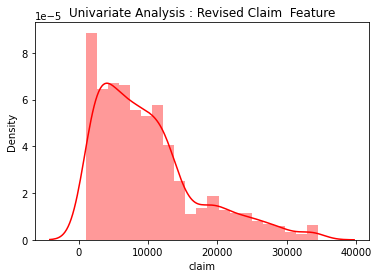

In [40]:
## Re-running the Univariate analysis on revised "claim" feature
sns.distplot(main_df.claim, color="r", kde=True).set(title='Univariate Analysis : Revised Claim  Feature')

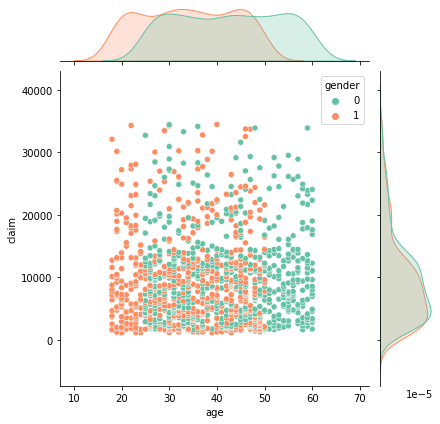

In [41]:
## EDA-Bivariate Analysis (Insranc Claim vs Age of Claimant)
sns.jointplot(data=main_df, x="age", y="claim", hue="gender", palette="Set2")

<AxesSubplot:>

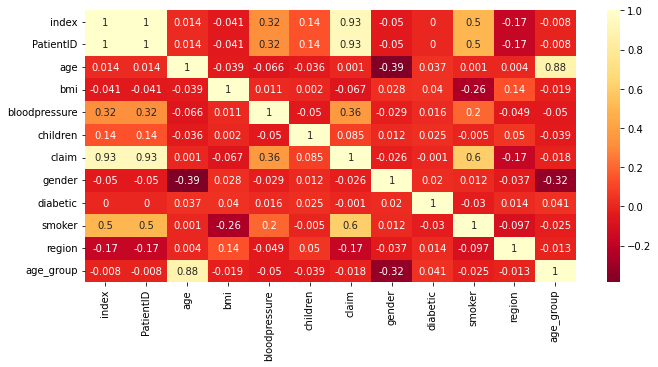

In [42]:
## Correlation map
corr = main_df.corr(method='pearson').round(3)
plt.figure(figsize=(11,5))
sns.heatmap(corr, annot=True, cmap="YlOrRd_r")

## Data Modeling

In [43]:
# Segregating the Dependent Variables in X and Independent Variable in Y
X = main_df.drop(columns=["claim"])
y = main_df["claim"]

## standardize the price data values to avoid biased outcome of predictions
scaler = StandardScaler()
x_scaled=scaler.fit_transform(X)

In [44]:
## split the data

X_train, X_test, y_train, y_test = train_test_split(x_scaled ,y, test_size=0.2, random_state=0)

## create function to fit models

model_preds = []

def fit_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = round(r2_score(y_test, y_pred),4)
    adj_r2 = round(1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1),4)
    mse = round(mean_squared_error(y_test, y_pred),4)
    mae = round(mean_absolute_error(y_test, y_pred),4)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
    model_preds.append([model_name, r2, adj_r2, mse, mae, rmse])
    print ("The R-Squared Value is: ", r2)
    print ("Adjusted R-Squared Value is: ", adj_r2)
    print("The Mean Squared error (MSE) is: ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Error (MAE) is: ", mae)

## model evaluation function
def model_eval():
    preds = pd.DataFrame(model_preds)
    preds.columns = ["Mod_Name", "R2 Value", "adj_R2", "MSE", "RMSE", "MAE"]
    return preds.sort_values(by="R2 Value", ascending=False)

In [45]:
## Linear Regression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

fit_model(lr_model, "Linear Regression")

The R-Squared Value is:  0.8836
Adjusted R-Squared Value is:  0.8825
The Mean Squared error (MSE) is:  6423662.7567
Root Mean Squared Error (RMSE):  2534.4946
Mean Absolute Error (MAE) is:  1659.7744


In [46]:
## Decision Trees

dectree_model = DecisionTreeRegressor()
fit_model(dectree_model, "Decision Tree Regressor")

The R-Squared Value is:  0.9993
Adjusted R-Squared Value is:  0.9993
The Mean Squared error (MSE) is:  39583.4012
Root Mean Squared Error (RMSE):  198.9558
Mean Absolute Error (MAE) is:  64.3486


In [47]:
## Random Forest

randfor_model = RandomForestRegressor()
fit_model(randfor_model, "Random Forest Regressor")

The R-Squared Value is:  0.9998
Adjusted R-Squared Value is:  0.9998
The Mean Squared error (MSE) is:  11383.8319
Root Mean Squared Error (RMSE):  106.695
Mean Absolute Error (MAE) is:  34.5309


In [48]:
## XG Boost

XGB_model = xgb.XGBRFRegressor()
fit_model(XGB_model, "XG Boost")

The R-Squared Value is:  0.9997
Adjusted R-Squared Value is:  0.9997
The Mean Squared error (MSE) is:  16540.4397
Root Mean Squared Error (RMSE):  128.6096
Mean Absolute Error (MAE) is:  72.1655


In [49]:
## KNN

knn_model = KNeighborsRegressor(n_neighbors=6)
fit_model(knn_model, "K-Neigbors Regressor")

The R-Squared Value is:  0.8346
Adjusted R-Squared Value is:  0.8331
The Mean Squared error (MSE) is:  9125781.3569
Root Mean Squared Error (RMSE):  3020.8908
Mean Absolute Error (MAE) is:  1801.8234


## Model Evaluation

In [50]:
model_eval()

,Mod_Name,R2 Value,adj_R2,MSE,RMSE,MAE
2,Random Forest Regressor,0.9998,0.9998,1.138383e+04,34.5309,106.6950
3,XG Boost,0.9997,0.9997,1.654044e+04,72.1655,128.6096
1,Decision Tree Regressor,0.9993,0.9993,3.958340e+04,64.3486,198.9558
0,Linear Regression,0.8836,0.8825,6.423663e+06,1659.7744,2534.4946
4,K-Neigbors Regressor,0.8346,0.8331,9.125781e+06,1801.8234,3020.8908


## Predictions

In [51]:
# Training the Model

modelETR = ExtraTreesRegressor()
modelETR.fit(X_train, y_train)
    
# Predict the model with test data

y_pred = XGB_model.predict(X_test)

In [52]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=main_df.merge(out,left_index=True,right_index=True)

In [53]:
result[['PatientID', 'age','gender','Price_actual','Price_pred']].sample(25)

,PatientID,age,gender,Price_actual,Price_pred
587,588,54.0,0,8232.64,8191.200195
75,76,30.0,1,1837.28,1750.880615
1010,1011,25.0,0,17081.08,17004.130859
431,432,38.0,1,6059.17,6076.037109
211,212,36.0,0,3227.12,3228.208496
55,56,21.0,1,1711.03,1750.789917
702,703,26.0,0,9861.03,9841.915039
838,839,52.0,0,11879.10,11936.564453
34,35,43.0,0,1631.67,1682.224731
1136,1137,32.0,0,24873.38,24828.546875
